Skin Cancer Classification Final Project

In [3]:
# importing dataset
import kagglehub
import os
import pandas as pd
import shutil

# Download latest version
# path = kagglehub.dataset_download("jaiahuja/skin-cancer-detection")

dataset_path = kagglehub.dataset_download("jaiahuja/skin-cancer-detection")

# Move/copy to current working directory in Colab
!mkdir -p /content/SkinCancer
shutil.copytree(dataset_path, '/content/SkinCancer', dirs_exist_ok=True)


# Paths you can use for PyTorch ImageFolder
train_path = '/content/SkinCancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path  = '/content/SkinCancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test'


100%|██████████| 786M/786M [00:03<00:00, 211MB/s]

Extracting files...


In [4]:
# declaring global variables
BATCH_SIZE = 32
HEIGHT_IMG = 180
WIDTH_IMG = 180

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import os
import matplotlib.pyplot as plt
# import glob

transform = transforms.Compose([
    transforms.Resize((HEIGHT_IMG, WIDTH_IMG)),
    transforms.ToTensor(),
])
import os
print("Current working directory:", os.getcwd())
print("Contents:", os.listdir())

train_data = datasets.ImageFolder(train_path, transform=transform)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = datasets.ImageFolder(test_path, transform=transform)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# images, labels = next(iter(train_loader))
# print(f'Image batch shape: {images.size()}')
# print(f'Label batch shape: {labels.size()}')





Current working directory: /content
Contents: ['.config', 'SkinCancer', 'sample_data']


In [6]:

validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)


        # fully connected layers
        self.fc1 = nn.Linear(30976, 128)
        self.fc2 = nn.Linear(128, 9)  # Assuming binary classification

    def forward(self, x):
        # x /= 255.0  # Normalize input to [0, 1]

        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)
        # remember to always zero out the gradient first. Don't want old values
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # tracking prog
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / total
    train_loss_epoch = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            # optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = 100 * val_correct / total_val
    val_loss_epoch = val_loss / len(val_loader)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.9897, Accuracy: 24.78%


  5%|▌         | 1/20 [00:26<08:20, 26.32s/it]

Validation Loss: 1.8583, Validation Accuracy: 31.54%
Epoch 2/20, Loss: 1.7958, Accuracy: 36.27%


 10%|█         | 2/20 [00:52<07:53, 26.32s/it]

Validation Loss: 1.9668, Validation Accuracy: 31.54%
Epoch 3/20, Loss: 1.5238, Accuracy: 47.66%


 15%|█▌        | 3/20 [01:19<07:28, 26.38s/it]

Validation Loss: 1.3846, Validation Accuracy: 52.35%
Epoch 4/20, Loss: 1.3380, Accuracy: 54.24%


 20%|██        | 4/20 [01:44<06:56, 26.05s/it]

Validation Loss: 1.3470, Validation Accuracy: 51.68%
Epoch 5/20, Loss: 1.3182, Accuracy: 53.68%


 25%|██▌       | 5/20 [02:10<06:28, 25.89s/it]

Validation Loss: 1.3609, Validation Accuracy: 50.56%
Epoch 6/20, Loss: 1.2030, Accuracy: 58.09%


 30%|███       | 6/20 [02:36<06:02, 25.90s/it]

Validation Loss: 1.3333, Validation Accuracy: 51.01%
Epoch 7/20, Loss: 1.1487, Accuracy: 59.10%


 35%|███▌      | 7/20 [03:01<05:35, 25.81s/it]

Validation Loss: 1.3869, Validation Accuracy: 48.10%
Epoch 8/20, Loss: 1.0718, Accuracy: 61.83%


 40%|████      | 8/20 [03:27<05:09, 25.80s/it]

Validation Loss: 1.4387, Validation Accuracy: 49.66%
Epoch 9/20, Loss: 1.0065, Accuracy: 64.29%


 45%|████▌     | 9/20 [03:53<04:43, 25.78s/it]

Validation Loss: 1.2783, Validation Accuracy: 55.26%
Epoch 10/20, Loss: 0.9463, Accuracy: 66.35%


 50%|█████     | 10/20 [04:19<04:17, 25.79s/it]

Validation Loss: 1.3605, Validation Accuracy: 51.01%
Epoch 11/20, Loss: 0.8516, Accuracy: 69.64%


 55%|█████▌    | 11/20 [04:44<03:51, 25.76s/it]

Validation Loss: 1.2773, Validation Accuracy: 52.57%
Epoch 12/20, Loss: 0.7940, Accuracy: 70.70%


 60%|██████    | 12/20 [05:10<03:26, 25.76s/it]

Validation Loss: 1.3612, Validation Accuracy: 54.59%
Epoch 13/20, Loss: 0.7306, Accuracy: 72.99%


 65%|██████▌   | 13/20 [05:36<03:00, 25.80s/it]

Validation Loss: 1.4459, Validation Accuracy: 50.56%
Epoch 14/20, Loss: 0.6438, Accuracy: 76.00%


 70%|███████   | 14/20 [06:02<02:34, 25.73s/it]

Validation Loss: 1.4416, Validation Accuracy: 54.36%
Epoch 15/20, Loss: 0.5678, Accuracy: 78.35%


 75%|███████▌  | 15/20 [06:27<02:08, 25.78s/it]

Validation Loss: 1.5803, Validation Accuracy: 54.14%
Epoch 16/20, Loss: 0.5286, Accuracy: 80.80%


 80%|████████  | 16/20 [06:53<01:43, 25.76s/it]

Validation Loss: 1.6630, Validation Accuracy: 56.15%
Epoch 17/20, Loss: 0.4745, Accuracy: 81.58%


 85%|████████▌ | 17/20 [07:19<01:17, 25.71s/it]

Validation Loss: 1.8799, Validation Accuracy: 51.23%
Epoch 18/20, Loss: 0.3892, Accuracy: 85.27%


 90%|█████████ | 18/20 [07:44<00:51, 25.70s/it]

Validation Loss: 1.8642, Validation Accuracy: 48.32%
Epoch 19/20, Loss: 0.4105, Accuracy: 84.71%


 95%|█████████▌| 19/20 [08:10<00:25, 25.68s/it]

Validation Loss: 1.8158, Validation Accuracy: 51.23%
Epoch 20/20, Loss: 0.3288, Accuracy: 86.77%


100%|██████████| 20/20 [08:36<00:00, 25.81s/it]

Validation Loss: 1.9266, Validation Accuracy: 50.34%


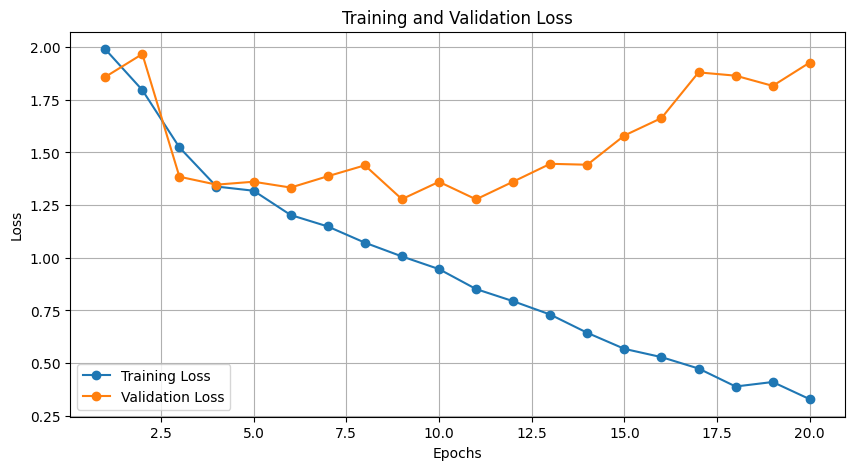

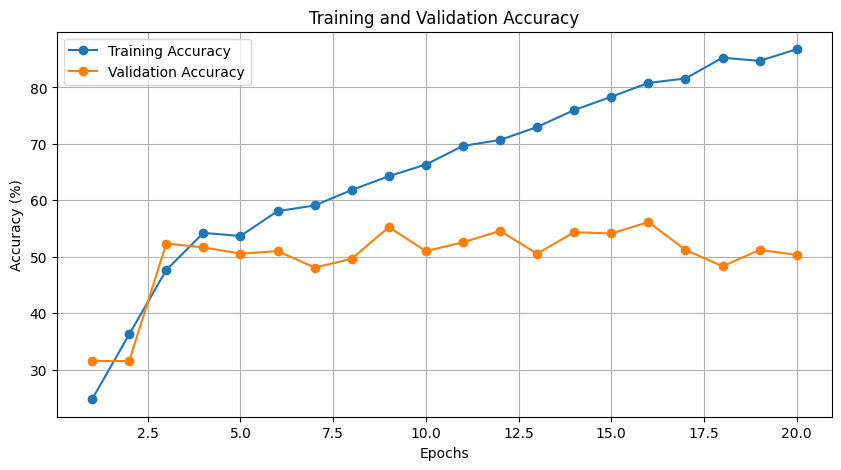

In [9]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

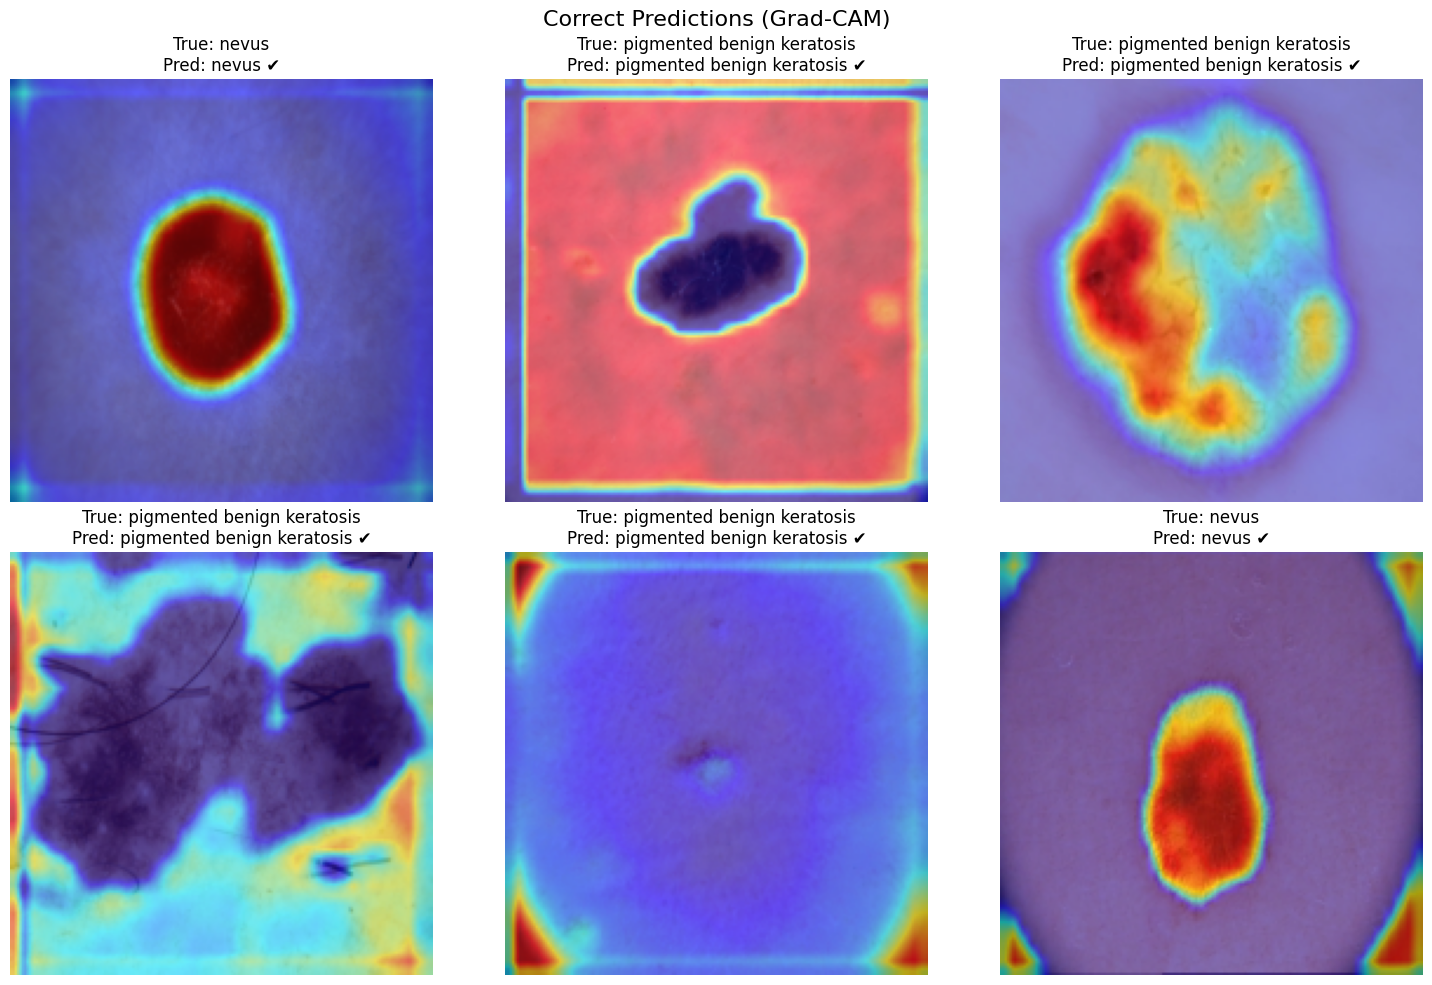

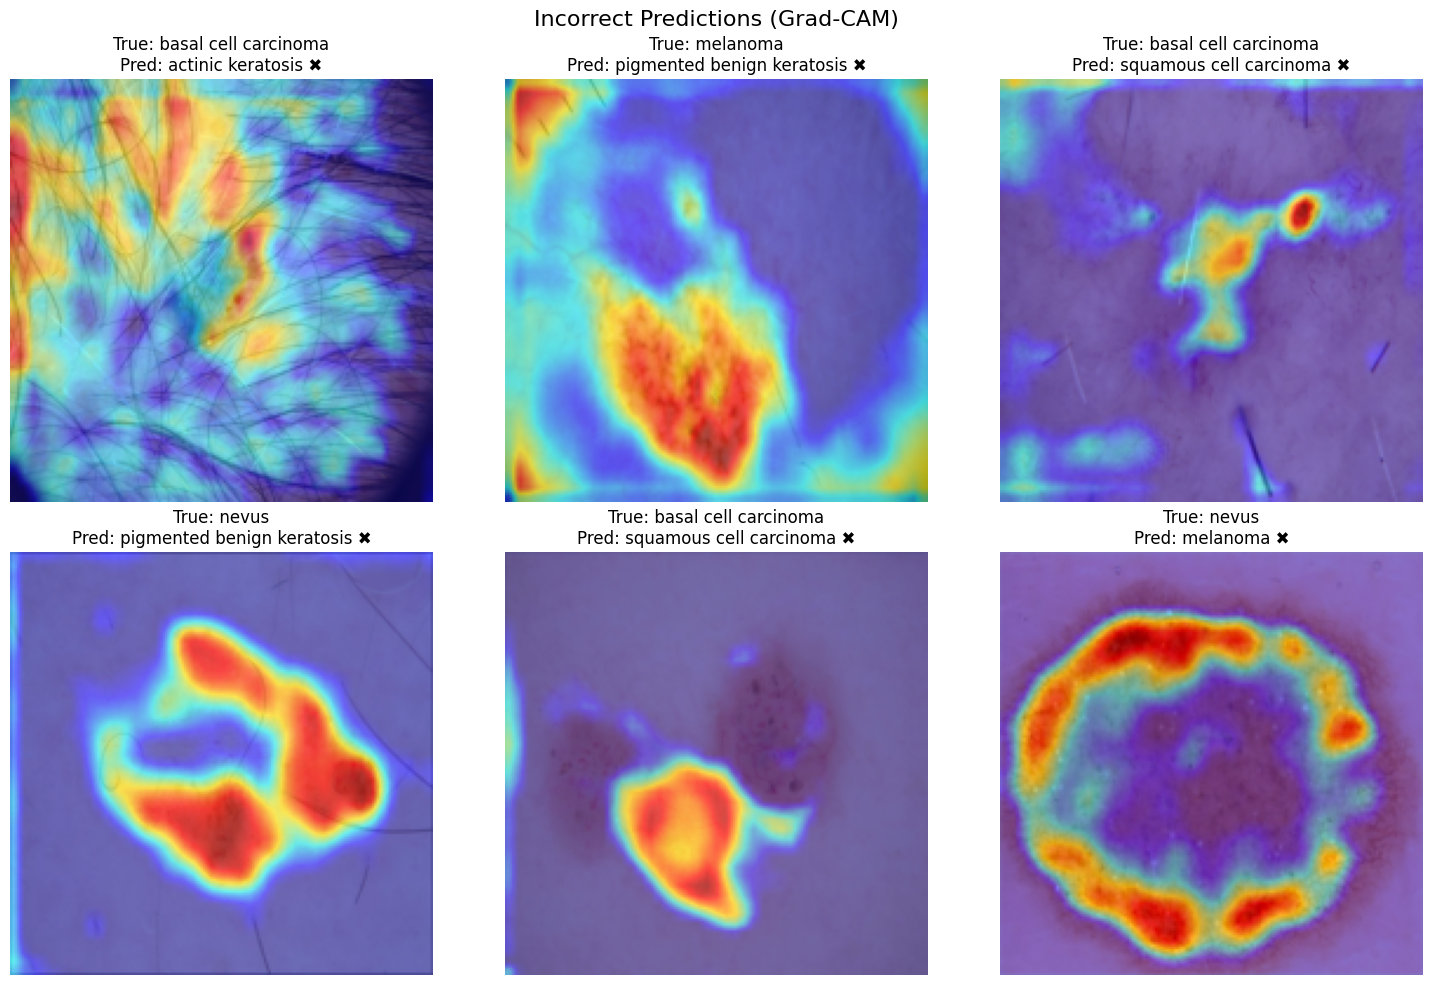

In [10]:
import matplotlib.pyplot as plt
import torch
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.conv3
cam = GradCAM(model=model, target_layers=[target_layer])

correct_images = []
incorrect_images = []

# Classify all validation images and separate them
for i in range(len(val_dataset)):
    img, true_label = val_dataset[i]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred_label = torch.max(outputs, 1)
        pred_label = pred_label.item()

    correct = (true_label == pred_label)
    # Store tuples (img, true_label, pred_label)
    if correct:
        correct_images.append((img, true_label, pred_label))
    else:
        incorrect_images.append((img, true_label, pred_label))

# Function to plot Grad-CAM for a list of images
def plot_gradcam(images_list, title, num_display=6):
    plt.figure(figsize=(15,10))
    for i in range(min(num_display, len(images_list))):
        img, true_label, pred_label = images_list[i]
        input_tensor = img.unsqueeze(0).to(device)
        rgb_img = img.permute(1,2,0).cpu().numpy()

        grayscale_cam = cam(input_tensor=input_tensor)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        true_class = train_data.classes[true_label]
        pred_class = train_data.classes[pred_label]

        plt.subplot(2, 3, i+1)
        plt.imshow(visualization)
        plt.title(f"True: {true_class}\nPred: {pred_class} {'✔' if true_label==pred_label else '✖'}")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot correct predictions
plot_gradcam(correct_images, "Correct Predictions (Grad-CAM)")

# Plot incorrect predictions
plot_gradcam(incorrect_images, "Incorrect Predictions (Grad-CAM)")
